# Food Safety and Machine Learning: Food Hazard Detection for SemEval 2025

Part of the competition [*SemEval 2025 Task 9: The Food Hazard Detection Challenge*](https://github.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io) held by *EFSA (European Food Safety Authority)*:

---

> Evangelia Kapetanaki<br />
> AM: 8210050<br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> Major: Data Analysis and Software Technologies <br />
> t8210050@aueb.gr

***"Food is the moral right of all who are born into this world."***

*– Norman Borlaug*, the Nobel Price Winner for his role on the Development of Agriculture (Green Revolution), who showed the world that the fight for safe food is a fight for life.

* His words apply for all and especially for those harmed by unsafe food (Poor Food Safety) or the absence of food altogether (Poor Food Security).

* It is society's responsibility to ensure that everyone has access to safe and reliable nourishment.

* In this assignment we will talk specifically about unsafe food.

* **Food Safety** is the process of "handling, preparing, and storing food in ways that prevent foodborne illness (also known as food poisoning)" ([Wikipedia](https://en.wikipedia.org/wiki/Food_safety)).

* Another useful term is **Food Hazard** which is "the biological, chemical or physical agent in a food that has potential to cause health effects" and which deems a food item as unsafe for consumption ([Science Direct](https://www.sciencedirect.com/topics/food-science/food-safety-hazard)).

* Unfortunately, there have been countless instances where food has been recalled due to inadequate safety regulations or rushed distribution without adequate test driven by profit over safety.

* According to World Health Organization (WHO) Newsroom page (2024, found [here](https://www.who.int/news-room/fact-sheets/detail/food-safety)):

    * Contaminated food affects $600$ million people annually, leading to $420.000$ deaths globally, with children under 5 years old bearing a disproportionate burden, accounting for 125,000 deaths annually due to foodborne diseases.
      
    * Unsafe food costs $110$$ billion annually in productivity losses and medical expenses.
 
* Food safety is a serious issue that needs strong efforts to address and solve. Leveraging technology in this context can help find even better solutions.

* This assignment is part of the **SemEval 2025 Task 9: The Food Hazard Detection Challenge** held by **EFSA (European Food Safety Authority)**, which sets the challenge: how can machine learning be used for food hazard detection in recalls.

* The challenge includes $2$ sub tasks and data for the training, test and validation of the machine learning model.


# Summary of aproach and results

* This assignment was a real challenge and a big journey that was full of hard work and constant tries of new things.

* Behind this assignment lay many hours of continuous tries, failures and successes.

* Our final results are:

    * **SubTask1: 0.7256**
    
    * **SubTask2: 0.4239**

* And our method implements

    * Thorough **Data Cleaning** using RegEx
    
    * **Data Augmentation** using **$13$ free LLM models** (API) on random similar prompts with fallback random **back-translation**.
    
    * SubTask1: **RoBERTa** (fine tuning).
    
    * SubTask2: Soft Voting of **RoBERTa and Random Forests** (fine tuning).
 
* AWS Sagemaker was utilized with total cost of approx. $200$ dollars with primary model `ml.g5.8xlarge`($2$ dollars per hour).

* Attention: In various instances such as in augmentation this notebook uses random methods so re-running may result in different results.

# Setup and Data Inspection

* Let's start by installing importing all the libraries we will need in our implementation.

* It's important to note that for this implementation of the assignment PyTorch Kernel is recommended.

In [ ]:
!pip install pandas numpy torch scikit-learn matplotlib tqdm joblib bs4 sentencepiece # basic for ML (might already be installed)

In [ ]:
!pip install nltk transformers datasets groq # more advanced ones (might not be installed)

In [57]:
# Core Libraries
import pandas as pd
import numpy as np
import re
import math
import time
import random
import copy
import itertools

# Tokenization - Language/Text Processing Libraries
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
import unicodedata
nltk.download('punkt_tab')
nltk.download("wordnet")

# Basic Classification Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, classification_report

# Transformer Libraries - PyTorch
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    AdamW, get_scheduler, DataCollatorWithPadding,
    MarianMTModel, MarianTokenizer
)
from datasets import Dataset

# Visualization
import matplotlib.pyplot as plt

# External LLM API (Groq)
from groq import Groq

# Others
from tqdm.auto import tqdm  # Progress bar
from concurrent.futures import ThreadPoolExecutor, as_completed  # Parallel processing
import joblib  # Model saving - loading
import getpass

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


* And now let's finally read our data.

In [58]:
data = pd.read_csv('incidents_train.csv', index_col=0)
print(data.shape)
pd.set_option('display.max_colwidth', None) # display the full text
data.sample(1, random_state=30)

(5082, 10)


,year,month,day,country,title,text,hazard-category,product-category,hazard,product
4371,2020,8,13,us,"Serafin Fishery Issues Allergy Alert on Undeclared Anchovies, Eggs, Milk and Soy in Salmon Dip and Whitefish Dip","Serafin Fishery is recalling its 8-ounce containers of Salmon Dip and Whitefish Dip because they may contain undeclared anchovies, eggs, milk and soy. People who have allergies to anchovies, eggs, milk and soy run the risk of serious or life-threatening allergic reaction if they consume these products. The recalled Salmon Dip and Whitefish Dips were distributed locally in retail stores. The product comes in an 8-ounce, clear plastic package marked with lot #729 and lot #807 on the top and with expiration dates of August 12, 2020 and August 24, 2020 on the label. No illnesses have been reported to date in connection with this problem. The recall was initiated after it was discovered during an inspection conducted by the Michigan Department of Agriculture and Rural Development that the products’ labeling did not list all of the products’ ingredients. Production of the product has been suspended until FDA and the company are certain that the problem has been corrected. Individuals with an allergy or sensitivity to anchovies, eggs, milk and soy should not consume these products. Households that include individuals with an allergy or sensitivity to any of these allergens should dispose of the recalled product. Consumers who have purchased the 8-ounce packages of Salmon Dip and Whitefish Dip are urged to return them to the place of purchase for a full refund. Consumers with questions may contact Serafin Fishery at 1-989-879-4596, Monday thru Friday from 9 to 5 p.m.",allergens,"soups, broths, sauces and condiments",fish and products thereof,dip-sauce


In [12]:
category_counts = {
    "hazard-category": data["hazard-category"].nunique(), # unique categories for the column
    "product-category": data["product-category"].nunique(),
    "hazard": data["hazard"].nunique(),
    "product": data["product"].nunique()
}
pd.DataFrame(category_counts, index=["Count of Possible Values (Labels)"])

,hazard-category,product-category,hazard,product
Count of Possible Values (Labels),10,22,128,1022


The data provided include $5.082$ **food recall incidents**.

The columns at hand include:

* `year`, `month`, `day`, `country`: When and where the recall occurred.

* `title`: a small recall description.

* `text`: a detailed report of the food recall incident.

* And our target columns are:

    1. `hazard-category`: $10$ classes (ex. biological).
 
    2. `hazard`: $128$ specific sub levels of `hazard-category` (ex. salmonela).
 
    3. `product-category`: $22$ classes (ex. dairy).
 
    4. `product`: $1.022$ specific sub levels of `product-category` (ex. sausage).

* To better understand our data, and in specific our training data, we will use the existing analysis that can be found [here](https://github.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/blob/main/data/statstics_train.ipynb), which according to GitHub History was a kind contribution of [randlbem](https://github.com/randlbem).

* According to this analysis we can see that:

    * We have data of cases in the time period of 1994-2022 and there's a notable increase in the number of reported food hazard cases over the years, especially post-2010.
    
    * We have data for $9$ countries (United States, Australia, Canada, United Kingdom, Ireland, Hong Kong, North America, Singapore and Scotland). The majority of the data originates from a few countries, with the US having the largest share, followed by Australia and Canada.
    
    * Most importantly, the **distribution** of data across `hazard-category`, `hazard`, `product-category` and `product` columns (all our target columns) is **heavily imbalanced**.

* So in other words, our training data are quite problematic.

* Since this imbalance problem is of utmost importance in our case we will also visualize it for reasons of completeness (the code used for this visualization is a slight modification from [randlbem](https://github.com/randlbem)'s kind contribution) using the same y-axis and subplots to make it easy for the reader to understand the case.

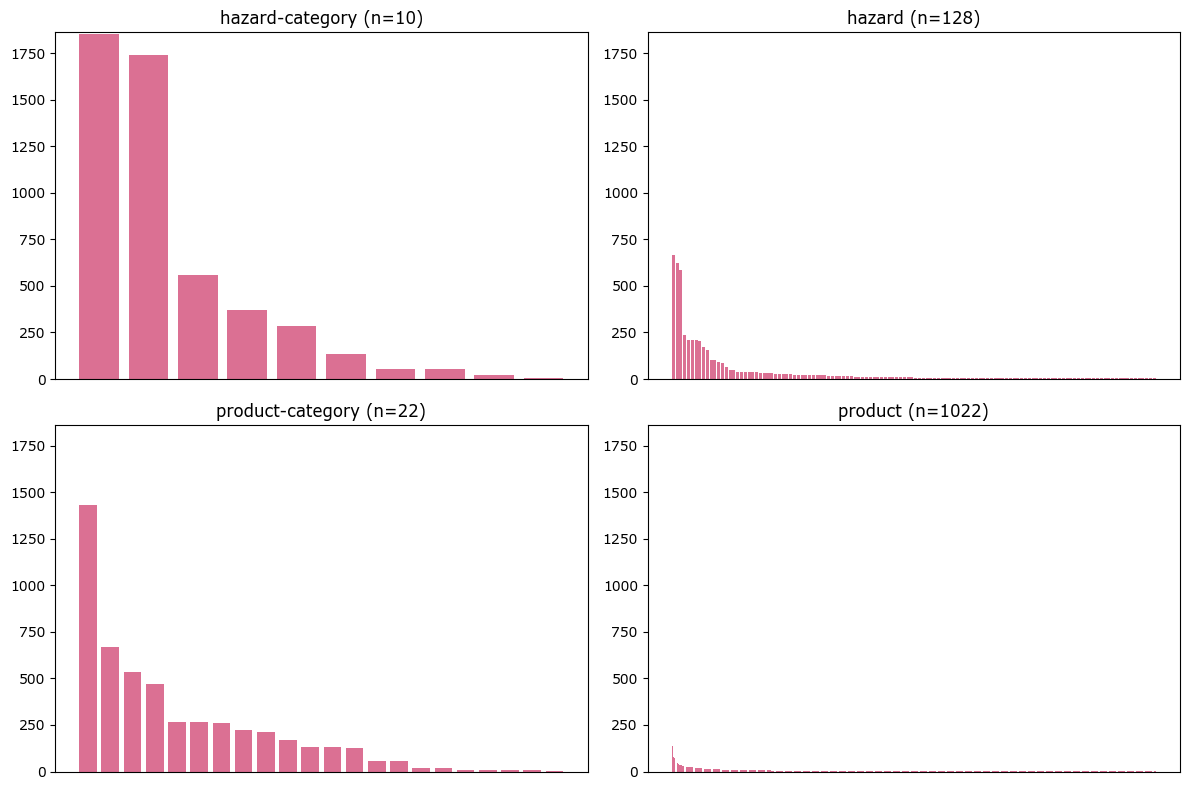

In [35]:
def print_column(ax, incidents: pd.DataFrame, column: str, global_y_max: int):
    """Plots a bar chart for the given column in a specified subplot axis."""
    values, counts = np.unique(incidents[column].dropna().astype(str).values, return_counts=True)
    # Sort values (count)
    idx = np.argsort(counts)[::-1]
    values = values[idx]
    counts = counts[idx]
    ax.bar(range(len(counts)), counts, color="palevioletred")
    ax.set_title(f'{column} (n={len(values):d})')
    ax.set_xticks([])  # Remove x-axis labels since we have too many categories

    # consistent Y-axis limits across all subplots
    ax.set_ylim(0, global_y_max)

fig, axes = plt.subplots(2, 2, figsize=(12, 8)) # 2x2 subplots
columns = ["hazard-category", "hazard", "product-category", "product"]
all_counts = []
for column in columns:
    _, counts = np.unique(data[column].dropna().astype(str).values, return_counts=True)
    all_counts.append(max(counts))
global_y_max_haz = max(all_counts) * 1.05
for ax, column in zip(axes.flatten(), columns):
    print_column(ax, data, column, global_y_max)
plt.tight_layout()
plt.show()

* From the above the following are clear:
  
    * In all target columns few categories dominate, while many others have very low occurrences (long tail distribution).
      
    * Especially in `hazard` and `product` we have many rare instances.

# Defining the problem

* To understand better what we must do we will use an example.

* Let's say there was a recall with title :  "Company X, Chicken recalled due to salmonella contamination".

* From such a recall we must create a Machine Learning Model that classifies the recall as:
      
    * `hazard-category`: biological
      
        * `hazard` :  salmonella
     <br>
     
    * `product-category`: meat, egg, and dairy products
      
        * `product` : chicken
     <br>
      
* The task is a **classification problem**, specifically a **text-based, multi-class classification problem on imbalanced data** (supervised learning), where:

    * *Text-Based*: The input is unstructured textual data (the title of a recall) from which the model must extract relevant information to make accurate predictions.

    * *Multi-Class*: For each target column, the model must predict exactly 1 class.
 
    * *Imbalanced Data*: As we mentioned before some hazard categories, hazards, product categories and products are more far more frequent than others.
 
* The task can be broken down into two sub-tasks:

    1. **ST1 - High-Level Classification** (Broad Categories): In this sub-task, the model must predict the high-level categories: `hazard-category`,  `product-category`.

    2. **ST2 - Fine-Grained Classification** (Specific Labels): In this sub-task, the model must predict the detailed, specific classes: `hazard`,
`product`.
 
* The evaluation for this task is based on the **macro F1 score** (0-1) to ensure fair treatment of all classes, including the less frequent ones. The macro (not weighted) F1 score is computed separately in ST1 and ST2 for both hazard labels and product labels (of the rows correctly predicted for hazard-category), with the final score of the subtask being an average of these values.

* So we write the function to have the score calculations ready for when needed.

In [92]:
def compute_final_score(hazards_true, products_true, hazards_pred, products_pred):
    # Compute F1-score for hazards
    f1_hazards = f1_score(
        hazards_true, 
        hazards_pred, 
        average='macro')
    print("F1 Hazard Category: ", f1_hazards)
    
    # Compute F1-score for products
    f1_products = f1_score(
        products_true[hazards_pred == hazards_true],
        products_pred[hazards_pred == hazards_true],
        average='macro'
    )
    print("F1 Product Category: ", f1_products)
    
    final_f1 = (f1_hazards + f1_products) / 2
    return final_f1

## A Peak at the Solutions by the team

* It would be wrong to continue with this project without seeing previous implementations if we really want to build a good model. We should note the good and bad points of previous implementations to decide if we should use or refrain from using parts of these approaches.

* Down below is a presentation of the suggested code approaches that can be found [here](https://github.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/tree/main/code) in the GiHub page of the project after evaluation.

| **Approach** | **Simple Description** | **Strengths** | **Weaknesses**|
|--------------|------------------------|---------------|---------------|
| **TF-IDF + Logistic Regression** | Count words and classify using a basic model.| Lightweight and computationally efficient with not too bad F1 scores (st1: $0.449$, st2: $0.121$).| Does not capture semantic relationships or handle complex, hierarchical, or rare classes effectively. |
| **BERT (Google's transformer model) Adaptation (=Fine Tuning)**| Use a pre-trained language model for classification.| Provides text understanding and better F1 scores (st1: $0.591$, st2: $0.112$).| Requires significant computational resources (GPU).|
| **CICLe (Conformal In-Context Learning) with TF-IDF + Logistic Regression + LLM Prompting (Using Cosine Similarity)** | Focus only on relevant candidate classes| Intelligent way of narrowing down the candidate classes and probably handles low support categories (writer has not provided scores).|Highly complex and LLM loading (preparation) needs high computational power and memory even tho predictions later might be fast (but dependent on GPU to support an LLM locally).|


# Data Cleaning

* Before we move into our model we should check if your data are cleaned and healthy.

* If we don't have clean data it seems impossible to be able to make a quality model.

* It will be like trying to teach a student with low-quality excercises.

* Our first step would be to remove any possible `NaN` values so we go ahead and do that.

In [36]:
data.dropna(inplace=True)

In [37]:
data.isna().sum()

year                0
month               0
day                 0
country             0
title               0
text                0
hazard-category     0
product-category    0
hazard              0
product             0
dtype: int64

* Now comes a difficult but important task : our data is raw text (titles and text regarding a recall) but are they of high quality?

* Let's see our $2$ basic problems with our title and text data.

**1.** **Titles that are unclear** about both hazard and product (or only the product). Samples of which are presented down below.

In [82]:
data[data['title'].str.split().str.len() < 5]['title'].sample(5, random_state=50).to_frame()

,title
920,Recall Notification Report 057-2013
1945,AC Creamery Inc. Recalls
25,Recall Notification: FSIS-010-97
241,Pavlova Pantry—Lamingtons
697,Archives


* For example "Recall Notification: FSIS-010-97" or "Archives" are not clear about neither product nor hazard.

* And "Pavlova Pantry-Lamingtons" are clear only about the product.

In [83]:
len(data[data['title'].str.split().str.len() < 5])

224

* Most of these types of titles have a small amout of words and by assuming they have up to $5$ words each we already have $224$ rows with titles with non-complete or none at all information.

**2. Text of inconsistent format and inconsistent length.**

* Taking a look at the texts every text seems its own format. Below we see a few examples.

In [66]:
data['text'].sample(5, random_state=100).to_frame()

,text
1622,CVS Pharmacy® announced today that it has voluntarily recalled select cases of Gold Emblem Aboun...
564,PRA No. 2011/12802 Date published 8 Sep 2011 Product description 400g Macro Whole Foods Market G...
591,Page Content EKO Australia Pty Ltd has recalled 3 varieties of Kamfen brand noodles: Buckwheat N...
5380,Food Recall Warning - Sliced White Mushrooms prepared for Metro Brands recalled due to Listeria ...
3841,Notice This archive of previously issued food recalls and allergy alerts is provided for referen...


* And of course, some people tend to write more extensively than others who are more laconic giving a range of use of words from $10$ to $8.406$.

In [92]:
text_lengths = data['text'].str.split().str.len()
print("Text varies from", text_lengths.min(), "words up to", text_lengths.max(),
          "with a mean of", round(text_lengths.mean(), 2), 
          "and standard deviation of", round(text_lengths.std(), 2))

Text varies from 10 words up to 8406 with a mean of 353.25 and standard deviation of 297.66


* Since titles and text must be of high value for our model to learn we will use a thorough approach and clean the `text` column up with **RegEx** while ensuring that titles are replaced by our clean verison of text if they are not of high value.

* Something we can definatelly assume by looking at our `text` column is that most of the times the hazard and the product of the recall are being mentioned on the 1st or 2nd sentance.

* So it would be useful to find a way to split sentences.

* The best way is to split at every dot.

* But there is a problem with that.

* Written language many times (and especially in content such as recall of products) contain abbreviations with dots like "oz." or "etc." or numbers with dots as decimals like "$24.5$". So we must find a way to split our sentences taking this into account.

* So we must protect abbreviations that have approximately $1-4$ words and number decimals. Our approach is:

    * Find these instances in the text.
 
    * Replace the dot of the abbreviation or number with a placeholder (<<DΟT>> was used).
 
    * Split sentences based on dots that now don't have to do with abbreviations or numbers.
 
    * Replace the placeholders of the abbreviation or number with the dots.

In [59]:
def protect_decimals(text):
    return re.sub(r'(\d)\.(\d)', r'\1<<DOT>>\2', text) #E.g. "8.25" becomes "8<<DOT>>25"

def protect_abbrevs(text):
   # For example, "oz." becomes "oz<<DOT>>.
    text = re.sub(r'\b([a-zA-Z]{1,4})\.', r'\1<<DOT>>', text) # most abbreviations
    # List of additional abbreviations to protect.
    abbrevs = {"calif", "haccp", "approx"}
    for abbr in abbrevs:
        pattern = r'\b' + abbr + r'\.'
        replacement = abbr + "<<DOT>>"
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text

def restore_placeholders(text):
    return text.replace("<<DOT>>", ".")

# Splits text into sentences on periods protecting abbreviations
def custom_sentence_split(text):
    protected_text = protect_decimals(text)
    protected_text = protect_abbrevs(protected_text)
    
    parts = protected_text.split('.') # Split on period.
    sentences = [p.strip() for p in parts if p.strip()]
    
    # Restore placeholders in each sentence.
    sentences = [restore_placeholders(s) for s in sentences]
    return sentences

* Let's see how we did.

In [100]:
sample_text = ("The FDA issued a recall notice for FreshFarm Inc.'s 12.5 oz. mixed berries due to E. coli contamination. "
               "Consumers who purchased these items between approx. 02.10.2024 and 03.05.2024 are advised to discard the products. "
               "Testing by USDA-FSIS confirmed the presence of Listeria monocytogenes. "
               "For refunds, contact FreshFarm Ltd. at 1-800-555-0123. Additional details can be found on www.fda.gov.")
sentences = custom_sentence_split(sample_text)
print(sentences)

["The FDA issued a recall notice for FreshFarm Inc.'s 12.5 oz. mixed berries due to E. coli contamination", 'Consumers who purchased these items between approx. 02.10.2024 and 03.05.2024 are advised to discard the products', 'Testing by USDA-FSIS confirmed the presence of Listeria monocytogenes', 'For refunds, contact FreshFarm Ltd. at 1-800-555-0123', 'Additional details can be found on www.fda.gov.']


* We managed to split the sentances correctly.

* However, splitting text in sentences and getting the 1st or 1st & 2nd sentences is not as realistic in our case where there are many formats of text and sometimes the information may be a bit later in the text.

* So we use a more thorough way of approaching the issue: checking the real excel data, noting the most dominant formats and finding ways to extract information from them while tackling the rest with a specific default method based on getting the first sentences only.

* More specifically :

1. We do some basic text cleaning: remove HTML tags, ensure consistent unicode encoding, make letters lower case.
 
2. Then we handle all dominant cases:

| Case | Condition | Cleaned Text |
|------|-----------|-----------------|
| **1** | Case starts with `"case"` | Extracts **Product, Problem, and Description** from specific format of text, formats them as: `<PRODUCT> recalled due to <PROBLEM> (<DESCRIPTION>)` |
| **2** | Case starts with `"pra no."` | Uses the **title** as the product and extracts **hazards** from specific format of text, formatted as: `<PRODUCT> recalled due to <HAZARD>` |
| **3** | Case starts with `"newsroom > food recalls and allergy alerts > archives"` | Returns the **title** directly: `<TITLE>` |
| **4** | Case starts with `"washington"` | Returns the **first sentence** of the text: `<EXTRACTED INFO>` |
| **5** | Case starts with `"notice"` | Returns the **title**: `<TITLE>` |
| **6** | Case starts with `"food alert"` | Returns the **title**: `<TITLE>` |
| **7** | Case starts with `"risk"` | Returns the **title**: `<TITLE>` |
| **8** | Case starts with a numerical pattern | Returns the **title**: `<TITLE>` |
| **9** | Default (Other Cases) | Uses **custom sentence splitting** and gets the 1st only sentence if "recall" or "presence" is involved otherwise gets both the 1st and 2nd sentence: `<EXTRACTED INFO>` |

3. Then we removed numbers in the text, slaces, trailing whitespace etc. (not informational in our context)

In [60]:
def extract_relevant_info(text, title=""):
    if "<" in text and ">" in text:
            text = BeautifulSoup(text, "html.parser").get_text()
    text = unicodedata.normalize("NFKD", text)
    text = text.lower().strip()
 
    # 1: Text starts with "case" 
    if text.startswith("case"):
        product_match = re.search(r"(?i)product:\s*(.*?)\s*(?:problem:|$)", text)
        problem_match = re.search(r"(?i)problem:\s*(.*?)\s*(?:description:|total pounds recalled:|$)", text)
        description_match = re.search(r"(?i)description:\s*(.*?)\s*(?:total pounds recalled:|$)", text)
        
        product_info = product_match.group(1).strip() if product_match else ""
        problem_info = problem_match.group(1).strip() if problem_match else ""
        description_info = description_match.group(1).strip() if description_match else ""
        
        if product_info and problem_info and description_info:
            result = f"{product_info} recalled due to {problem_info} ({description_info})"
        elif product_info and problem_info:
            
            result = f"{product_info} recalled due to {problem_info}"
        elif product_info:
            result = product_info
        else:
            result = ""
            
    # 2: Text starts with "pra no."
    elif text.startswith("pra no."):
        # Use custom_sentence_split in the "pra no." branch.
        sentences = custom_sentence_split(text)
        hazard_sentence = ""
        for s in sentences:
            if "what are the defects?" in s:
                hazard_sentence = s.strip()
                break
        if hazard_sentence:
            hazard_text = re.sub(r"^what are the defects?\??\s*", "", hazard_sentence, flags=re.IGNORECASE).strip()
        else:
            hazard_text = ""
        product_info = title.strip() if title else ""
        result = f"{product_info} recalled. {hazard_text}"
    
    # 3: Text starts with "newsroom > food recalls and allergy alerts > archives"
    elif text.startswith("newsroom > food recalls and allergy alerts > archives"):
        result = title.strip() if title else ""

    # 4: Text starts with "washington"
    elif "washington" in text:
       washington_index = text.find("washington")
       new_text = text[washington_index:]
       sentences = custom_sentence_split(new_text)
       result = sentences[0] if sentences else new_text
       result = re.sub(r"^washington[,\s]*", "", result).strip()
    
    # 5: Text starts with "notice"
    elif text.startswith("notice"):
        result = title.strip() if title else ""
    
    # 6: Text starts with "food alert"
    elif text.startswith("food alert"):
        result = title.strip() if title else ""
    
    # 7: Text starts with "risk"
    elif text.startswith("risk"):
        result = title.strip() if title else ""
        
    # 7: Text starts with "page content"
    elif text.startswith("page content"):
        sentences = custom_sentence_split(text)
        if sentences:
            problem_match = re.search(r"problem:?\s+(.*?)(?:\.|$)", sentences[0], flags=re.IGNORECASE)
        else:
            problem_match = re.search(r"problem:?\s+(.*?)(?:\.|$)", text, flags=re.IGNORECASE)
        if problem_match:
            problem_text = problem_match.group(1).strip()
            result = f"{title.strip()} {problem_text}"
        else:
            result = title.strip() if title else ""

    # 8: Text starts with a numeric pattern like "18-2022", "025-2022", or "PHA-07122022-01"
    elif re.match(r"^(?:pha-)?\d{1,5}-\d{2,5}", text, flags=re.IGNORECASE):
        result = title.strip() if title else ""

    # (Small check not significant - promiment)
    elif "the above product" in custom_sentence_split(text)[0]:
        sentences=custom_sentence_split(text)
        problem_match = re.search(r"problem\s*(.*?)(?:\.|$)", sentences[0], flags=re.IGNORECASE)
        if problem_match:
            problem_text = problem_match.group(1).strip()
            result = f"{title.strip()} {problem_text}"
        else:
            result = title.strip() if title else ""

    # Default: Other texts
    else:
        sentences = custom_sentence_split(text)
        if len(sentences) > 0:
            # if the first sentence contains "products listed below", join the first and second sentences.
            if "products listed below" in sentences[0]:
                if len(sentences) > 1:
                    result = sentences[0] + " " + sentences[1]
                else:
                    result = sentences[0]
            elif re.search(r"\b(recall\w*|presence)\b", sentences[0], re.IGNORECASE):
                result = sentences[0]
            else:
                result = " ".join(sentences[:2]) if len(sentences) > 1 else sentences[0]
        else:
            result = ""
    
    result = re.sub(r"\d+", "", result)
    result = re.sub(r"[/\-]", " ", result)
    result = re.sub(r"[^\x00-\x7F]+", " ", result)
    result = re.sub(r"\s+", " ", result).strip()
    return result

* So based on this text cleaning we will create a new column `clean-text` with that information.

*  Additionally:

    *  For "Recall Notifications" we will use the `clean-text` as the `title` too since these rows always have titles like "Recall Notification (Number)"
    
    *  And assuming that sometimes our method may not be perfect at all times we will use the title to replace cases with too many or too little words.

In [61]:
def clean_text(data):
    data['clean-text'] = data.apply(lambda row: extract_relevant_info(row['text'], title=row['title'].lower()), axis=1)
    data.loc[data['title'].str.lower().str.startswith("recall notification:"), 'title'] = data['clean-text']
    data.loc[data['title'].str.lower().str.startswith("archives"), 'title'] = data['clean-text']
    data.loc[data['clean-text'].str.split().str.len() < 5, 'clean-text'] = data['title']
    data.loc[data['clean-text'].str.split().str.len() > 100, 'clean-text'] = data['title']
    return data

* So let's see what we got.

In [62]:
data = clean_text(data)
pd.set_option('display.max_colwidth', 250)
data['clean-text'].sample(5, random_state=20).to_frame()

,clean-text
1365,the ooo company recalls all varieties of its infused oils and vacuum packed halloumi cheese because of concerns over its procedures in place to control clostridium botulinum
2597,"specialty commodities, inc., (sci) of fargo, n.d., a subsidiary of archer daniels midland company (adm), is recalling a specific lot of dry roasted almonds because they may contain undeclared cashews"
1471,the real lancashire black pudding co ltd is recalling a batch of its black pudding slices because the product has been incorrectly labelled with a use by date of december
2601,weis markets today announced it had issued a recall for its pre made penne pasta with asiago sauce and grilled chicken single serving meal for failing to list a milk allergen on its label
5154,"notification pc brand roquefort blue cheese recalled due to generic e. coli from: canadian food inspection agency recall advisory date: july , reason for recall advisory: microbiological other hazard classification: class company firm: loblaws in..."


In [147]:
text_lengths = data['clean-text'].str.split().str.len()
print("Text varies from", text_lengths.min(), "words up to", text_lengths.max(),
          "with a mean of", round(text_lengths.mean(), 2), 
          "and standard deviation of", round(text_lengths.std(), 2))

Text varies from 1 words up to 100 with a mean of 40.85 and standard deviation of 23.46


* We can now say that we have something a bit better to move on.

# Data Augmentation

* Data Cleaning however is not enough preparation for training a machine learning model on the data at hand.

* We need to address the imbalance issue we mentioned earlier.

* Some of the best practices for this kind of issue is **Data Augmentation** which is to artificially expand a dataset by applying transformations to the existing dataset to create new, varied samples.

* There are specific ways to perform Data Augmentation for each data type (numeric, image, text).

* As for text, which is our case we tried the methods below:

| **Method** | **How it works** | **Performance in practice** | **Accepted/Denied** |
|------------|---------------|-----------------|------------|
| **Synonyms** | Replaced words with synonyms using wordnet. | Poor performance as it did not understand the context, creating sentences without actual meaning. | **Rejected** |
| **BERT (Masked Language Modeling)** | Randomly masked words in a sentence and used BERT to predict and replace them. | Good in theory, but generated sentences that lacked meaning. | **Rejected** |
| **Back-Translation** | Translated text into another language and then back to English. | Introduced little variation but preserved meaning well. | **Accepted** |
| **LLM Paraphrasing** | Used a large language model (LLM) to rephrase sentences while keeping the meaning intact. | Performed well, successfully preserving the original meaning while improving text diversity. | **Accepted** |

* So our final augmentation method is : LLM Paraphrasing and Back-Translation.

* More specifically we use:

    * LLM Paraphrasing with $2$ attempts randomly at $13$ LLM models.
 
    * If the $2$ attempts fail (due to API Call Limit per Minute) then fallback to BackTranslation.
 
* Why $13$ LLM models?

  1) to overcome API Call Limit per Minute
     
  2) to enhance diversity using different model architectures

* To enhance diversity even more we randomly use a slightly different prompt across $7$ prompts.

* Among the LLM Models we use is Deepseek R1 (a new leader in LLMs) and various versions of Llama.

* And all this is for **free**, since its a competition and we play a fair game, using [**Groq**](https://en.wikipedia.org/wiki/Groq).

* **Groq** was chosen because we wanted access to a big amount of LLMs (for variablity) and a **free** ability to call them multitle times and Groq provides limits per day per model that start at $1.000$ calls a day and go up to $14.400$ calls a day for each model with a limit of $30$ calls per minute for each seperate model. By randomly chosing between $13$ models we increase our chances of getting a response by an LLM model.

* In the fallback option, backtranslation, we use $3$ languages (French, German, Spanish) from which we chose again randomly to ensure some variation.

* Of cource we must note that to have access to Groq you sign up and log in (for example by using  your gmail) [here](https://console.groq.com/login). (No bank information is asked from you). And then you just make an API key which can be used at the code below. When you run this code you will be asked to give as input your API key.

In [63]:
API_KEY = getpass.getpass("Enter your Groq API Key: ")
try:
    client = Groq(api_key=API_KEY)
    print("Connected to Groq successfully.")
except Exception as e:
    print(f"Connection failed: {e}")

Enter your Groq API Key:  ········


Connected to Groq successfully.


* These are the models we will use

In [64]:
models = [
    "deepseek-r1-distill-llama-70b",
    "llama-3.3-70b-versatile",
    "llama-3.3-70b-specdec",
    "llama-3.2-1b-preview",
    "llama-3.2-3b-preview",
    "llama-3.1-8b-instant",
    "llama3-70b-8192",
    "llama3-8b-8192",
    "llama-guard-3-8b",
    "mixtral-8x7b-32768",
    "gemma2-9b-it",
    "llama-3.2-11b-vision-preview",
    "llama-3.2-90b-vision-preview"
]

* These are the different prompts we will use (slightly different emphasis on rewording/variation, describing/details/expanding and sentence stracture modification per prompt).

In [65]:
augmentation_prompts = [
    "Reword with different phrasing and word choices.",
    "Generate a more descriptive version while keeping the original meaning.",
    "Paraphrase this with a different sentence structure.",
    "Rewrite this in a slightly more detailed way with varied vocabulary.",
    "Modify while maintaining its intent, but add variation.",
    "Rephrase in a creative way without changing its core message.",
    "Expand slightly while using different word choices."
]

* And this is how we call our API, randomly selecting our model, prompt and then augmenting the row by making a copy of a row with a new title and a new clean text.

* It is important to note the importance of **making a good prompt** as if the prompt is not **specific** enough (ex. we did not put "Deliver only the modified text. Do not add explanations, extra text, or formatting.") the model would return unnessecary text like "My response is that: ...", "i think ... because...".

* Also we have put $0.9$ as temperature to get some variation from there too.

* If the $2$ attempts fail it returns the row unchanged and a flag "False" which will indicate Back-Translation to handle the row, otherwise it returns the modified row and the flag as True.

In [66]:
def augment_text_llm(row, text_col, title_col, max_retries=2):
    for attempt in range(max_retries):
        try:
            model_choice = random.choice(models)  # Select model
            aug_prompt = random.choice(augmentation_prompts)  # Select prompt
            # text augmentation
            text_prompt = f"""
            You are an AI specialized in improving recall descriptions. Your goal is to modify the following text 
            while ensuring the core meaning remains intact.{aug_prompt}

            Original Text: {row[text_col]}

            Deliver only the modified text. Do not add explanations, extra text, or formatting.
            """
            response_text = client.chat.completions.create(
                model=model_choice,
                messages=[
                    {"role": "system", "content": "You are a helpful AI assistant."},
                    {"role": "user", "content": text_prompt}
                ],
                max_tokens=300,
                temperature=0.9,
                top_p=0.9
            )
            new_text = response_text.choices[0].message.content.strip()

            # title augmentation
            title_prompt = f"""
            You are an AI specialized in improving recall titles.  Your goal is to modify the following title
            while ensuring the core meaning remains intact.{aug_prompt}

            Original Title: {row[title_col]}

            Deliver only the modified title. Do not add explanations, extra text, or formatting.
            """
            response_title = client.chat.completions.create(
                model=model_choice,
                messages=[
                    {"role": "system", "content": "You are a helpful AI assistant."},
                    {"role": "user", "content": title_prompt}
                ],
                max_tokens=100,
                temperature=0.9,
                top_p=0.9
            )
            new_title = response_title.choices[0].message.content.strip()

            # Update row
            row[text_col] = new_text
            row[title_col] = new_title
            return row, True
        except Exception as e:
            time.sleep(2)
    return row, False

* So let's try it in action with a test.

In [167]:
test_row = {
    "text_col": "The FDA issued a recall notice for FreshFarm Inc.'s 12.5 oz. mixed berries due to E. coli contamination."
               "Consumers who purchased these items between approx. 02.10.2024 and 03.05.2024 are advised to discard the products.",
    "title_col": "FDA Recalls Frozen Berries",
}
augment_text_llm(test_row, "text_col", "title_col", max_retries=2)

({'text_col': "The FDA has announced a recall of FreshFarm Inc.'s 12.5 oz mixed berry products, which have been found to be contaminated with E. coli. As a precautionary measure, customers who bought these berries between approximately February 10, 2024, and March 5, 2024, are urged to dispose of them immediately.",
  'title_col': 'FDA Issues Recall of Frozen Berry Products'},
 True)

* The rephrasal is indeed very good and each time we run that test we will get a different result.

* Now that we established the augmentation using LLMs let's see the Back-Translation.

* Down below we also have our BackTranslation Setup with **Helsinki-NLP’s MarianMT models** (Language Technology Research Group at the University of Helsinki).

* These models follow the format : Helsinki-NLP/opus-mt-{src}-{tgt} and specifically return a varied version of the initial text when used in Back-Translation

* Sources:

    * [https://huggingface.co/docs/transformers/model_doc/marian](https://huggingface.co/docs/transformers/model_doc/marian) and
    
    * [https://huggingface.co/Helsinki-NLP](https://huggingface.co/Helsinki-NLP)

In [67]:
src_lang = "en"  # English
tgt_langs = ["fr", "de", "es"]  # French, German, Spanish

# for each language pair load the translation model
translators = {}
for tgt in tgt_langs:
    translators[(src_lang, tgt)] = {
        "tokenizer": MarianTokenizer.from_pretrained(f"Helsinki-NLP/opus-mt-en-{tgt}"),
        "model": MarianMTModel.from_pretrained(f"Helsinki-NLP/opus-mt-en-{tgt}")
    }
    translators[(tgt, src_lang)] = {
        "tokenizer": MarianTokenizer.from_pretrained(f"Helsinki-NLP/opus-mt-{tgt}-en"),
        "model": MarianMTModel.from_pretrained(f"Helsinki-NLP/opus-mt-{tgt}-en")
    }

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


* And we also create the methods that run the model using forward translation to our randomly chosen language and back translation to English for a specific row text and title. 

In [68]:
def translate_text(text, from_lang, to_lang):
    tokenizer = translators[(from_lang, to_lang)]["tokenizer"]
    model = translators[(from_lang, to_lang)]["model"]

    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    translated_tokens = model.generate(**inputs)
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

    return translated_text

def augment_text_backtranslation(text):
    # Pick random target language
    tgt_lang = random.choice(tgt_langs)

    # Forward & backward translation
    translated_text = translate_text(text, src_lang, tgt_lang)
    backtranslated_text = translate_text(translated_text, tgt_lang, src_lang)

    return backtranslated_text

* So let's try the same example as with the LLM, but this time with Back-Translation.

In [73]:
original_text = "The FDA issued a recall notice for FreshFarm Inc.'s 12.5 oz. mixed berries due to E. coli contamination. Consumers who purchased these items between approx. 02.10.2024 and 03.05.2024 are advised to discard the products. "
augmented_text = augment_text_backtranslation(original_text)

print("Original:", original_text)
print()
print("Augmented:", augmented_text)

Original: The FDA issued a recall notice for FreshFarm Inc.'s 12.5 oz. mixed berries due to E. coli contamination. Consumers who purchased these items between approx. 02.10.2024 and 03.05.2024 are advised to discard the products. 

Augmented: The FDA issued a notice of withdrawal for FreshFarm Inc. of 12.5 ounces of mixed berries due to E. coli contamination. Consumers who bought these items between 02.10.2024 and 03.05.2024 are advised to discard the products.


* It is obvious that LLMs provide significantly greater diversification compared to Back-Translation.

* However, Back-Translation still introduces subtle variations in sentences, offering a reasonable level of diversity for a ML model.

* Additionally, Back-Translation is far more cost-effective than LLM-based augmentation, making it a practical fallback for large-scale data augmentation.

* Combining the $2$ we have the `augment_text` method using the primary and fallback mechanism and the `apply_augmentation` method that handles the whole dataset's augmentation based on `max_aug_per_category` which we give to it. Its job is to augment the data so that **all labels-categories are in at least `max_aug_per_category` number of rows**.

In [74]:
def augment_text(row, text_col, title_col, max_retries=2):
    row, success = augment_text_llm(row, text_col, title_col, max_retries)

    # If the LLM-based augmentation failed, use back-translation
    if not success:
        row[text_col] = augment_text_backtranslation(row[text_col])
        row[title_col] = augment_text_backtranslation(row[title_col])
        return row

    return row

In [75]:
def apply_augmentation(df, category_col, text_col, title_col, max_aug_per_category):
    category_counts = df[category_col].value_counts()
    total_augmentations_needed = sum(max_aug_per_category - count for count in category_counts if count < max_aug_per_category)
    total_augmentations_done = 0
    augmented_data = []
    futures = []

    with ThreadPoolExecutor(max_workers=20) as executor:
        for category, count in category_counts.items():
            num_to_augment = max_aug_per_category - count
            if num_to_augment > 0:
                category_samples = df[df[category_col] == category]

                if len(category_samples) < num_to_augment:
                    sample_iterator = itertools.cycle(category_samples.sample(frac=1).iterrows())
                else:
                    sample_iterator = category_samples.sample(n=num_to_augment, random_state=random.randint(1, 10000), replace=False).iterrows()

                for _, row in itertools.islice(sample_iterator, num_to_augment):
                    row_copy = copy.deepcopy(row.to_dict())  
                    future = executor.submit(augment_text, row_copy, text_col, title_col)
                    futures.append(future)

        for future in futures:
            try:
                new_row = future.result()
                total_augmentations_done += 1
                percent_done = (total_augmentations_done / total_augmentations_needed) * 100
                print(f"\rAugmenting {total_augmentations_done}/{total_augmentations_needed} ({percent_done:.2f}%)", end="", flush=True)
                augmented_data.append(new_row)
            except Exception as e:
                print(f"Augmentation task failed: {e}", flush=True)

    print("\n")  # New line after completion
    augmented_df = pd.DataFrame(augmented_data)
    return pd.concat([df, augmented_df], ignore_index=True)

* But now the question arises: **What is the minimum number of rows needed for the smallest category to tackle imbalance?**

* The answer is "According to the task and the data it uses".

* So we will use $2$ augmentations: $1$ for SubTask1 and $1$ for SubTask2.

* Why? To have better control over what we give to our model in each task since the labels are different.

* Since the label distributions differ between SubTask1 and SubTask2, applying the same augmentation strategy to both could introduce bias or unnecessary noise.

* So for task $1$ we have:

In [174]:
data['hazard-category'].value_counts()

hazard-category
allergens                         1854
biological                        1741
foreign bodies                     561
fraud                              371
chemical                           287
other hazard                       134
packaging defect                    54
organoleptic aspects                53
food additives and flavourings      24
migration                            3
Name: count, dtype: int64

In [175]:
data['product-category'].value_counts()

product-category
meat, egg and dairy products                         1434
cereals and bakery products                           671
fruits and vegetables                                 535
prepared dishes and snacks                            469
seafood                                               268
soups, broths, sauces and condiments                  264
nuts, nut products and seeds                          262
ices and desserts                                     222
cocoa and cocoa preparations, coffee and tea          210
confectionery                                         170
non-alcoholic beverages                               134
dietetic foods, food supplements, fortified foods     131
herbs and spices                                      125
alcoholic beverages                                    59
other food product / mixed                             55
pet feed                                               20
fats and oils                                          

* So by looking at these distributions we will augment at $100$ both of them.

In [77]:
print("Augmenting products...")
train_data_1 = apply_augmentation(data, category_col="product-category", text_col="clean-text", title_col="title", max_aug_per_category=100)
print("Finished Product Augmentation")

print("Augmenting hazards...")
train_data_1 = apply_augmentation(train_data_1, category_col="hazard-category", text_col="clean-text", title_col="title", max_aug_per_category=100)
print("Finished Hazard Augmentation")

Augmenting products...
Augmenting 713/713 (100.00%)

Finished Product Augmentation
Augmenting hazards...
Augmenting 183/183 (100.00%)

Finished Hazard Augmentation


* So for task $2$ we have:

In [187]:
 data['hazard'].value_counts().min(), round(data['hazard'].value_counts().mean()), data['hazard'].value_counts().max()

(3, 40, 665)

In [186]:
 data['product'].value_counts().min(), round(data['product'].value_counts().mean()), data['product'].value_counts().max()

(1, 5, 185)

* So by looking at these distributions we will augment at $10$ the product one and at $40$ the hazard one.

In [18]:
print("Augmenting products...")
train_data_2 = apply_augmentation(data, category_col="product", text_col="clean-text", title_col="title", max_aug_per_category=10)
print("Finished Product Augmentation")

print("Augmenting hazards...")
train_data_2 = apply_augmentation(treain_data_2, category_col="hazard", text_col="clean-text", title_col="title", max_aug_per_category=40)
print("Finished Hazard Augmentation")

Augmenting products...
Augmenting 6903/6903 (100.00%)

Finished Product Augmentation
Augmenting hazards...
Augmenting 2142/2142 (100.00%)

Finished Hazard Augmentation


* The reason we did not pursue more augmentation is the danger of overfitting. 

* Because even tho paraphrasing helps tackle overifitting, if we make $300$ product recalls from paraphrasing $1$ recall our model will not learn but learn by hart which means that it will only be able to indentify the product if it is a paraphrase of that $1$ recall.

* Finally we read our validation & test data which we downloaded from [here](https://github.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/tree/main/data).

* And we perform the text cleaning procedures we followed with our train data as well.

In [79]:
val_data = clean_text(pd.read_csv("incidents_valid.csv"))
test_data = clean_text(pd.read_csv("incidents_test.csv"))

# SubTask1: Predicting Hazard - Category & Product - Category

* We will start our fist task using first the simplest approach to get a first idea of what we will be trying to build on and use it as a benchmark for later models.

* So we will get this first idea using TF-IDF and Logistic Regression: a very fast and simple model.

* Also as we saw the `title` almost always mentions the product and the `clean-text` almost always mentions the hazard, so we will use them to predict `product-category` and `hazard-category` respectively. 

In [ ]:
train_data = train_data_1 # Use the 1st augmentation

In [81]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=20000) # Vectorization
X_train = vectorizer.fit_transform(train_data['clean-text'])
X_test = vectorizer.transform(test_data['clean-text'])
X_train_2 = vectorizer.fit_transform(train_data['title'])
X_test_2 = vectorizer.transform(test_data['title'])

# Labels (for both product and hazard categories)
y_train_hazard = train_data['hazard-category']
y_test_hazard = test_data['hazard-category']
y_train_product = train_data['product-category']
y_test_product = test_data['product-category']

# Train & Fit Logistic Regression models
model_hazard = LogisticRegression(max_iter=1000, class_weight="balanced")
model_product = LogisticRegression(max_iter=1000, class_weight="balanced")
model_hazard.fit(X_train, y_train_hazard)
model_product.fit(X_train_2, y_train_product)

# Predict
y_pred_hazard = model_hazard.predict(X_test)
y_pred_product = model_product.predict(X_test_2)

# Compute final score
final_f1_score = compute_score(y_test_hazard , y_test_product, y_pred_hazard, y_pred_product)

print("Final Combined F1-Score:", final_f1_score)
print("\nHazard Classification Report:\n", classification_report(y_test_hazard, y_pred_hazard))
print("\nProduct Classification Report:\n", classification_report(y_test_product, y_pred_product))

Final Combined F1-Score: 0.6301464938578326

Hazard Classification Report:
                                 precision    recall  f1-score   support

                     allergens       0.93      0.88      0.91       365
                    biological       0.94      0.93      0.94       343
                      chemical       0.87      0.88      0.88        52
food additives and flavourings       0.33      0.50      0.40         4
                foreign bodies       0.95      0.87      0.91       111
                         fraud       0.62      0.73      0.67        75
                     migration       0.00      0.00      0.00         1
          organoleptic aspects       0.50      0.60      0.55        10
                  other hazard       0.53      0.62      0.57        26
              packaging defect       0.40      0.80      0.53        10

                      accuracy                           0.87       997
                     macro avg       0.61      0.68      0

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

* So with a very simple model we get a F1 Score of $0.63$.

* Not bad for a start.

* In fact it is approximately $0.20$ points higher than the provided code sample that uses the title (even tho not entirely comparable since test data are different- but stll).

* **This goes to show how important important data cleaning and augmentation is for a model.**

* However, we can do better.

* TF-IDF, while effective in weighting words based on frequency, lacks a crucial element: **context**. It treats words in isolation, missing the nuances that give them **true meaning** in a sentence.

* So what we will do is try to encorporate this meaning of language in our model.

* How do we do that?

* We turn to transformers, a groundbreaking and very smart development in Natural Language Processing (NLP).

* What transformers do is they use **contextual embeddings**, meaning they capture the meaning of a word based on the words around it (mechannism called **Self-Attention**).

* Below we present the some extremelly influential transformer-based models:

 | Model      | Year | Developed By | Characteristics |
|-----------|------|-------------|-------------|
| **BERT** (*Bidirectional Encoder Representations from Transformers*) | 2018 | Google AI | - Bidirectional context (words before and after target word)|
| **RoBERTa** (*Robustly Optimized BERT*) | 2019 | Facebook AI | - Better focus on 1 sentence tasks <br>- Trained on more data than BERT for longer <br> - More robust and accurate than BERT generaly|
| **DistilBERT** (*Distilled BERT*) | 2019 | Hugging Face | - fewer parameters than BERT<br>- 95% of BERT's performance with lower computational cost
| **DeBERTa** (*Decoding-enhanced BERT with Disentangled Attention*) | 2020 | Microsoft AI | - More advanced context representation than BERT/RoBERTa <br>- computationally heavy model with a lot of parameters| 

* As for DistilBERT, we won't be using it since our primary goal is F1-Score and not cost-efficiency.

* As for the others, based on the study *"BERT, RoBERTa or DeBERTa? Comparing Performance Across Transformers Models in Political Science Text"* by *Joan C. Timoneda and Sebastián Vallejo Vera*, published in The *Journal of Politics*, which examines the effectiveness of various transformer models in political science applications, it was found that **RoBERTa and DeBERTa often outperform BERT in specific scenarios**, particularly when fine-tuned for specialized texts.

* So we are between RoBERTa and DeBERTa.

* DeBERTa generally outperforms RoBERTa in the bibliography, but its size and complex mechanisms might overfit our data since they are not that many (close to $6.000$ rows with the subtask 1 augmentation) of text on average composed of $20$ words.

* So **let's try RoBERTa** which seems to be the most promicing using clean-text to predict `hazard-category` and `title` to predict `product-category` as we did in Logistic Regression. However, it is important to emphasize that **<ins>TRIAL AND ERROR WAS UTILIZED and the code below was rerun for all models with RoBERTa performing highest, DeBERTa extremelly low and BERT and DistilBERT at medium values close to RoBERTa.</ins>**

* So we now have text data and text labels.

* ML Models need numbers in both data and labels.

* So we must convert :

    1) The labels:
        * ex. ['listeria', 'allergy'] -> [0,1].
        
        * For this we use `LabelEncoder()` the tool that does excactly that.
    3) The text data (text and title):
    
       * ex. Suppose our "clean-text" is: "Listeria contamination can occur in refrigerated foods."
        
       * The tokenizer converts this into:
        ["Listeria", "contamination", "can", "occur", "in", "refrigerated", "foods", "."]
    
        * These tokens are then mapped to numerical IDs, making the text understandable to RoBERTa.
      
        * For this, we use `RobertaTokenizer.from_pretrained("roberta-base")`, which ensures our text follows the format RoBERTa expects.

* So this is what we do below.

In [ ]:
label_enc_hazard = LabelEncoder()
label_enc_product = LabelEncoder()

label_enc_hazard.fit(train_data["hazard-category"])
label_enc_product.fit(train_data["product-category"])
train_data["hazard_label"] = label_enc_hazard.transform(train_data["hazard-category"])
val_data["hazard_label"] = label_enc_hazard.transform(val_data["hazard-category"])
test_data["hazard_label"] = label_enc_hazard.transform(test_data["hazard-category"])
train_data["product_label"] = label_enc_product.transform(train_data["product-category"])
val_data["product_label"] = label_enc_product.transform(val_data["product-category"])
test_data["product_label"] = label_enc_product.transform(test_data["product-category"])

# RoBERTa Tokenizer loading
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_text(examples):
    return tokenizer(examples["clean-text"], padding="max_length", truncation=True)

def tokenize_title(examples):
    return tokenizer(examples["title"], padding="max_length", truncation=True)

* Now we must make our data ready for training by converting them data into a format that RoBERTa and PyTorch can understand (Hugging Face Datasets).

* Then, the data is prepared in batches of $16$ (an accepted general practice) using DataLoaders, making it ready for training the model. 

In [83]:
# DataFrames to Hugging Face Datasets
train_dataset_text = Dataset.from_pandas(train_data).map(tokenize_text, batched=True)
val_dataset_text = Dataset.from_pandas(val_data).map(tokenize_text, batched=True)
test_dataset_text = Dataset.from_pandas(test_data).map(tokenize_text, batched=True)
train_dataset_title = Dataset.from_pandas(train_data).map(tokenize_title, batched=True)
val_dataset_title = Dataset.from_pandas(val_data).map(tokenize_title, batched=True)
test_dataset_title = Dataset.from_pandas(test_data).map(tokenize_title, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True) # format compatible with PyTorch

train_dataset_text.set_format("torch", columns=["input_ids", "attention_mask", "hazard_label", "product_label"])
val_dataset_text.set_format("torch", columns=["input_ids", "attention_mask", "hazard_label", "product_label"])
test_dataset_text.set_format("torch", columns=["input_ids", "attention_mask", "hazard_label", "product_label"])
train_dataset_title.set_format("torch", columns=["input_ids", "attention_mask", "hazard_label", "product_label"])
val_dataset_title.set_format("torch", columns=["input_ids", "attention_mask", "hazard_label", "product_label"])
test_dataset_title.set_format("torch", columns=["input_ids", "attention_mask", "hazard_label", "product_label"])

# Create Dataloaders  for text and title
batch_size = 16
train_dataloader_text = DataLoader(train_dataset_text, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_text = DataLoader(val_dataset_text, batch_size=batch_size, collate_fn=data_collator)
test_dataloader_text = DataLoader(test_dataset_text, batch_size=batch_size, collate_fn=data_collator)

train_dataloader_title = DataLoader(train_dataset_title, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_title = DataLoader(val_dataset_title, batch_size=batch_size, collate_fn=data_collator)
test_dataloader_title = DataLoader(test_dataset_text, batch_size=batch_size, collate_fn=data_collator)


Map:   0%|          | 0/5978 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Map:   0%|          | 0/5978 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

* After preparing our data we will prepare our model(s).

* We start by enabling it to load and run in **"cuda"** which utilizes GPU, which is much faster than CPU in the case of such models as they are based on linear algebra (optimized on GPU).

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

* And we load $2$ models (pretrained RoBERTa base): $1$ to predict hazard category and $1$ to predict product category.

In [73]:
model_hazard = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_enc_hazard.classes_)).to(device)
model_product_title = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_enc_product.classes_)).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_depr

* This warning above just states that the model is not fully trained yet, which is what we want since we **will be fine-tuning it**.

* Now we must set our **fine-tuning strategy** of the RoBERTa-based classification models.

* This means finding the perfect combination of optimizer, loss, epochs, patience other methods like sceduling.

* **<ins>AT THIS POINT TRIAL AND ERROR WAS UTILIZED MULTIPLE, MULTIPLE TIMES.</ins>**

    Many different loss functions, learning rates, and patience values were tested to optimize performance. The best setup was chosen based on **empirical results and f1-macro metrics**.

| Method                    | Purpose                                      |  Notes after trial |
|---------------------------|----------------------------------------------|--------------------------|
| **AdamW (Weight Decay Adam)** | Optimizes weights efficiently while preventing overfitting with aim to generalize | Worked best alone in practice, even tho not comlete in theory |
| **Cross-Entropy Loss with Class Weights** | Assigns higher loss to minority classes |Good in theory performed lower than just AdamW|
| **Focal Loss** | Reduces the impact of easy-to-classify examples | Good in theory performed lower than just AdamW |
| **Augmenting**| Increases the number of minority class samples | Highly increased  scores when applied |
| **Learning Rate = 5e-5**| Good practice for fine-turning | Best Learning Rate |
| **Learning Rate = 1e-6**| Also Good practice for fine-turning (lower than 5e-5) | Slow without increasing the final score |
| **Early Stopping = 2**| Stop training at 2 epochs where validation FI-Score has not improved | Captures a good performance on both validation and testing data |
| **Early Stopping = 5**| Stop training at 5 epochs where validation FI-Score has not improved | Captures a very good performance on validation data but not as good in testing data |

* The final desicion was the following:
  
* AdamW optimizer : used to update model weights efficiently, with a learning rate of $5e-5$.
 

In [ ]:
optimizer_hazard = AdamW(model_hazard.parameters(), lr=5e-5)
optimizer_product_title = AdamW(model_product_title.parameters(), lr=5e-5)

* Early stopping (2 for 20 epochs): stopping training if the model does not improve after 2 epochs on the Validation Data F1 Macro score.

In [ ]:
num_epochs = 20  # Max epochs
patience = 2  # Stop if no improvement after 2 epochs

* Linear learning rate scheduler: gradually reduces the learning rate over time to improve training stability and prevent overfitting.

In [ ]:
num_training_steps = num_epochs * len(train_dataloader_text)
lr_scheduler_hazard = get_scheduler("linear", optimizer=optimizer_hazard, num_warmup_steps=0, num_training_steps=num_training_steps)
lr_scheduler_product_title = get_scheduler("linear", optimizer=optimizer_product_title, num_warmup_steps=0, num_training_steps=num_training_steps)

* The best model and F1-score are tracked separately for both hazard category and product category classification tasks in a history dictionary.

In [ ]:
best_f1 = {"hazard": 0, "product_title": 0}
no_improve_epochs = {"hazard": 0,"product_title": 0}
best_model = {"hazard": None, "product_title": None}
history = {"hazard_loss": [], "hazard_f1": [], "product_title_loss": [], "product_title_f1": []}

* Now after all this extensive preparation we are ready to train our models.

* First for Hazard:

In [74]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs} - Training Hazard Model")

    model_hazard.train()
    total_loss = 0

    for batch in train_dataloader_text:
        batch = {k: v.to(device) for k, v in batch.items()}

        if "hazard_label" not in batch:
            print("Skipping batch - No hazard labels found!")
            continue

        batch["labels"] = batch.pop("hazard_label").to(torch.long)
        inputs = {k: batch[k] for k in ["input_ids", "attention_mask", "labels"] if k in batch}
        outputs = model_hazard(**inputs)

        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        optimizer_hazard.step()
        lr_scheduler_hazard.step()
        optimizer_hazard.zero_grad()

    avg_loss = total_loss / len(train_dataloader_text)
    history["hazard_loss"].append(avg_loss)

    # Validation Step
    model_hazard.eval()
    val_preds, true_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader_text:
            batch = {k: v.to(device) for k, v in batch.items()}
            if "hazard_label" not in batch:
                continue  # Skip if no labels
            true_labels.extend(batch["hazard_label"].cpu().numpy())

            inputs = {k: batch[k] for k in ["input_ids", "attention_mask"]}
            outputs = model_hazard(**inputs)

            predictions = torch.argmax(outputs.logits, dim=-1)
            val_preds.extend(predictions.cpu().numpy())

    if len(true_labels) > 0:  # Prevent division by zero
        f1 = f1_score(true_labels, val_preds, average="macro", zero_division=1)
        history["hazard_f1"].append(f1)
        print(f"Validation Hazard F1-score: {f1:.4f}")

        # Early Stopping Check
        if f1 > best_f1["hazard"]:
            best_f1["hazard"] = f1
            no_improve_epochs["hazard"] = 0
            best_model["hazard"] = copy.deepcopy(model_hazard.state_dict())
        else:
            no_improve_epochs["hazard"] += 1
            if no_improve_epochs["hazard"] >= patience:
                print(f"Hazard model stopped early at epoch {epoch+1}. Best F1-score: {best_f1['hazard']:.4f}")
                break


Epoch 1/20 - Training Hazard Model
Validation Hazard F1-score: 0.6596

Epoch 2/20 - Training Hazard Model
Validation Hazard F1-score: 0.7524

Epoch 3/20 - Training Hazard Model
Validation Hazard F1-score: 0.7510

Epoch 4/20 - Training Hazard Model
Validation Hazard F1-score: 0.7998

Epoch 5/20 - Training Hazard Model
Validation Hazard F1-score: 0.7871

Epoch 6/20 - Training Hazard Model
Validation Hazard F1-score: 0.7861
Hazard model stopped early at epoch 6. Best F1-score: 0.7998


* Hazard Model showed a steady improvement in F1-score over the first few epochs, reaching a peak of $0.7998$ at epoch $4$.

* However, after this point, the performance declined slightly ($0.7871$ → $0.7861$), triggering early stopping at epoch $6$ due to no further improvement.

* Now let's see how product does:

In [75]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs} - Training Product (Title) Model")

    model_product_title.train()
    total_loss = 0

    for batch in train_dataloader_title:
        batch = {k: v.to(device) for k, v in batch.items()}

        if "product_label" not in batch:
            print("Skipping batch - No product labels found!")
            continue

        batch["labels"] = batch.pop("product_label").to(torch.long)

        inputs = {k: batch[k] for k in ["input_ids", "attention_mask", "labels"] if k in batch}
        outputs = model_product_title(**inputs)

        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        optimizer_product_title.step()
        lr_scheduler_product_title.step()
        optimizer_product_title.zero_grad()

    avg_loss = total_loss / len(train_dataloader_title)
    history["product_title_loss"].append(avg_loss)

    # Validation Step
    model_product_title.eval()
    val_preds, true_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader_title:
            batch = {k: v.to(device) for k, v in batch.items()}
            if "product_label" not in batch:
                continue
            true_labels.extend(batch["product_label"].cpu().numpy())

            inputs = {k: batch[k] for k in ["input_ids", "attention_mask"]}
            outputs = model_product_title(**inputs)

            predictions = torch.argmax(outputs.logits, dim=-1)
            val_preds.extend(predictions.cpu().numpy())

    if len(true_labels) > 0:
        f1 = f1_score(true_labels, val_preds, average="macro", zero_division=1)
        history["product_title_f1"].append(f1)
        print(f"Validation Product (Title) F1-score: {f1:.4f}")

        if f1 > best_f1["product_title"]:
            best_f1["product_title"] = f1
            no_improve_epochs["product_title"] = 0
            best_model["product_title"] = copy.deepcopy(model_product_title.state_dict())
        else:
            no_improve_epochs["product_title"] += 1
            if no_improve_epochs["product_title"] >= patience:
                print(f"Product (Title) model stopped early at epoch {epoch+1}. Best F1-score: {best_f1['product_title']:.4f}")
                break



Epoch 1/20 - Training Product (Title) Model
Validation Product (Title) F1-score: 0.5689

Epoch 2/20 - Training Product (Title) Model
Validation Product (Title) F1-score: 0.6277

Epoch 3/20 - Training Product (Title) Model
Validation Product (Title) F1-score: 0.6406

Epoch 4/20 - Training Product (Title) Model
Validation Product (Title) F1-score: 0.6536

Epoch 5/20 - Training Product (Title) Model
Validation Product (Title) F1-score: 0.6738

Epoch 6/20 - Training Product (Title) Model
Validation Product (Title) F1-score: 0.6940

Epoch 7/20 - Training Product (Title) Model
Validation Product (Title) F1-score: 0.6797

Epoch 8/20 - Training Product (Title) Model
Validation Product (Title) F1-score: 0.6470
Product (Title) model stopped early at epoch 8. Best F1-score: 0.6940


* The Product (Title) Model demonstrated a steady increase in F1-score, reaching its peak of $0.6940$ at epoch $6$.

* However, in epochs $7$ and $8$, the performance declined ($0.6797$ → $0.6470$), leading to early stopping at epoch $8$.

* Let's now visualize all this. NOTE: the following graphs do not start at 0 in the y axis.

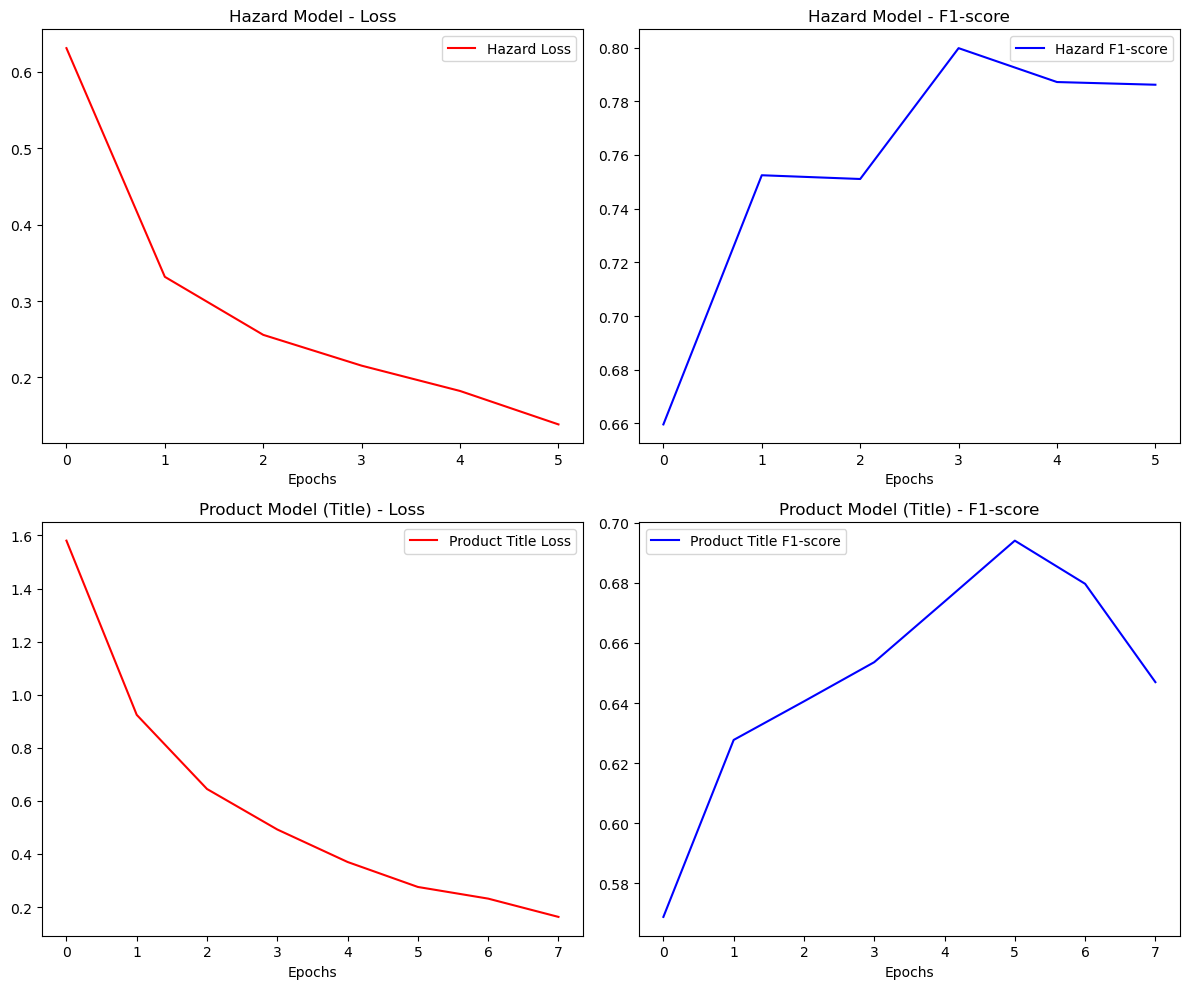

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Hazard Model
axes[0, 0].plot(history["hazard_loss"], label="Hazard Loss", color="red")
axes[0, 0].set_title("Hazard Model - Loss")
axes[0, 1].plot(history["hazard_f1"], label="Hazard F1-score", color="blue")
axes[0, 1].set_title("Hazard Model - F1-score")

# Product (Title)
axes[1, 0].plot(history["product_title_loss"], label="Product Title Loss", color="red")
axes[1, 0].set_title("Product Model (Title) - Loss")
axes[1, 1].plot(history["product_title_f1"], label="Product Title F1-score", color="blue")
axes[1, 1].set_title("Product Model (Title) - F1-score")

for ax in axes.flatten():
    ax.legend()
    ax.set_xlabel("Epochs")
plt.tight_layout()
plt.show()

*  We see that in both models the training loss was lower than $0.2$ in the last performing epoch meaning that probably the model has learned most general patterns and if loss goes lower might overfit.

* So to evaluate the models on our testing data we will load the best ones (had best F1 Macro on validation on their epoch).

In [193]:
if best_model["hazard"] is not None:
    model_hazard.load_state_dict(best_model["hazard"])
    print("Best hazard model loaded.")
if best_model["product_title"] is not None:
    model_product_title.load_state_dict(best_model["product_title"])
    print("Best product model loaded.")

Best hazard model loaded.
Best product model loaded.


* And we make our predictions on the testing data down below.

* In the end we turn the labels from numbers back to strings.

In [194]:
model_hazard.eval()
model_product_title.eval()

test_hazard_logits, test_product_logits_title = [], []
true_hazards, true_products = [], []

with torch.no_grad():
    # The Hazard Model
    for batch in test_dataloader_text:
        batch = {k: v.to(device) for k, v in batch.items()}
        true_hazards.extend(batch["hazard_label"].cpu().numpy())

        # Prepare input for RoBERTa
        inputs = {k: batch[k] for k in ["input_ids", "attention_mask"]}
        outputs = model_hazard(**inputs)

        # Collect hazard logits
        test_hazard_logits.extend(outputs.logits.cpu().numpy())

    # The Product Model (Title)
    for batch in test_dataloader_title:
        batch = {k: v.to(device) for k, v in batch.items()}
        true_products.extend(batch["product_label"].cpu().numpy())

        # Prepare inputs for RoBERTa
        inputs = {k: batch[k] for k in ["input_ids", "attention_mask"]}
        outputs = model_product_title(**inputs)

        # Collect product logits
        test_product_logits_title.extend(outputs.logits.cpu().numpy())

# Go back to labels
true_hazards = label_enc_hazard.inverse_transform(true_hazards)
test_hazard_preds = label_enc_hazard.inverse_transform(np.argmax(test_hazard_logits, axis=1))

true_products = label_enc_product.inverse_transform(true_products)
test_product_preds = label_enc_product.inverse_transform(np.argmax(test_product_logits_title, axis=1))

* So let's see what we got.

In [73]:
print("\nFinal Test Performance - Hazard Classification:")
print(classification_report(true_hazards, test_hazard_preds, zero_division=1))


Final Test Performance - Hazard Classification:
                                precision    recall  f1-score   support

                     allergens       0.85      0.98      0.91       365
                    biological       0.99      0.89      0.94       343
                      chemical       0.89      0.98      0.94        52
food additives and flavourings       0.50      1.00      0.67         4
                foreign bodies       0.97      0.92      0.94       111
                         fraud       0.95      0.75      0.84        75
                     migration       1.00      0.00      0.00         1
          organoleptic aspects       0.90      0.90      0.90        10
                  other hazard       0.85      0.65      0.74        26
              packaging defect       0.88      0.70      0.78        10

                      accuracy                           0.91       997
                     macro avg       0.88      0.78      0.76       997
             

* Not bad at all.

* Most of our categories were at a large percent calculated correctly.

* Allergens, Biological, Chemical, and Foreign Bodies all show strong, balanced performance, meaning the model reliably identifies these hazards.

* "Other Hazard" have low recall, meaning the model missed several actual instances.

* "Migration" is the biggest problem: the model never actually predicted this category (we had minimal training data for this one but even with augmentation we couldn't predict the $1$ case of migration in our test data)

* However total F1 Macro Score is $0.76$ which is really good and outperforms TFIDF Logistic Regression too by more than $0.10$.

In [74]:
print("\nFinal Test Performance - Product Classification (Best of Text & Title):")
print(classification_report(true_products, test_product_preds, zero_division=1))


Final Test Performance - Product Classification (Best of Text & Title):
                                                   precision    recall  f1-score   support

                              alcoholic beverages       1.00      0.50      0.67        16
                      cereals and bakery products       0.79      0.74      0.77       121
     cocoa and cocoa preparations, coffee and tea       0.82      0.76      0.79        42
                                    confectionery       0.51      0.70      0.59        33
dietetic foods, food supplements, fortified foods       0.59      0.62      0.60        26
                                    fats and oils       0.71      0.83      0.77         6
                   food additives and flavourings       0.50      0.50      0.50         4
                            fruits and vegetables       0.86      0.58      0.69       103
                                 herbs and spices       0.62      0.50      0.56        20
                

* In product we see a moderate performance.

* "Sugars and Syrups" (F1 = 1.00) performed perfectly, "Meat, Egg, and Dairy" (F1 = 0.84) and "Seafood" (F1 = 0.82) had both high recall and precision. "Ices and Desserts"  was also well-predicted.

* However, "Alcoholic Beverages" had high precision but low recall, meaning the model predicted this category rarely.  "Other Food Product / Mixed" shows poor generalization, likely due to overlapping features with other categories.

* In general however it achieves a good F1 Macro Score $0.68$

* And final score is:

In [75]:
print("\nTask 1 F1-Score:", round(compute_final_score(true_hazards, true_products, test_hazard_preds, final_product_preds), 4))

F1 Hazard Category:  0.7648688862882594
F1 Product Category:  0.6862328975928242

Task 1 F1-Score: 0.7256


* Task 1 F1-Score : $0.7256$.

* A good score for the difficulties of the dataset.

* We found our score but the report would be incomplete without an explanation over the model we are using.

In [204]:
model_hazard

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

* Its architecture goes as follows:
    1) **Embedding** Layer:
    Converts words into $768$-dimensional vectors using a **vocabulary of $50.265$ words**. Includes **position embeddings** (to track word order).
    2) **Transformer** Encoder (**$12$ Layers**):
    Uses self-attention to understand word **relationships in context** (multihead attention).
    3) **Classification** (ours):
    Converts the processed text into a prediction using: A fully connected (**dense**) layer (768 → 768). A final layer that outputs $10$ class predictions (768 → 10).

* Very important is the Dropout ($0.1$) that helps prevent overfitting, and its already existence in the model is why we did not add more drop out.

* As for parameters they are presented below:
| **Architecture Component**                     | **Calculation**                   | **Parameter Count** |
|-----------------------------------|----------------------------------|--------------------|
| **Embedding Layer**               |                                  | **$39.0M$**         |
| ├── Word Embeddings               | $50,265 × 768$                  | **$38.6M$**         |
| ├── Position Embeddings           | $514 × 768$                      | **$0.4M$**          |
| ├── Token Type Embeddings         | $1 × 768$                        | **$768$**           |
| ├── LayerNorm Parameters          | $2 × 768$                        | **$1,536$**         |
| **Transformer Encoder (12 Layers)** |                                  | **$85.0M$**         |
| ├── Self-Attention Weights (QKV)  | $3 × (768 × 768 + 768)$          | **$1.8M$** per layer |
| ├── Attention Output Layer        | $768 × 768 + 768$                | **$0.6M$** per layer |
| ├── Feedforward Layer 1           | $768 × 3072 + 3072$              | **$2.4M$** per layer |
| ├── Feedforward Layer 2           | $3072 × 768 + 768$               | **$2.4M$** per layer |
| ├── LayerNorm Parameters          | $2 × 768$                        | **$1,536$** per layer |
| **Total per Transformer Layer**   | Sum of above                     | **$7.1M$** per layer |
| **Total for 12 Layers**           | $7.1M × 12$                      | **$85.0M$**         |
| **Classification Head**           |                                  | **$0.6M$**          |
| ├── Fully Connected Layer         | $768 × 768 + 768$                | **$0.6M$**          |
| ├── Output Layer (10 classes)     | $768 × 10 + 10$                  | **$7,690$**         |
| **Total Parameters**              | Sum of all components            | **$124.6M$**        |

* The Transformer Encoder ($85.0M$) makes up **$68$%** of the total parameters.
* The Embedding Layer ($39.0M$) accounts for **$31$%** of the parameters.
* The Classification Head is relatively small at **$0.6M$** parameters.

* Very similarly we have the `product-category` model

In [205]:
model_product_text

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [77]:
df = pd.DataFrame({
    "true_hazard": true_hazards,
    "predicted_hazard": test_hazard_preds,
    "true_product": true_products,
    "predicted_product": test_product_preds
})
df.head(1)

,true_hazard,predicted_hazard,true_product,predicted_product
0,biological,biological,"meat, egg and dairy products","meat, egg and dairy products"


* To complete our analysis let's see what are the mostly confused labels.

* We will focus on the most prominent confusion but confusion matrix could be used alternativelly.

In [78]:
hazard_errors = df[df["true_hazard"] != df["predicted_hazard"]]
hazard_error_counts = (hazard_errors
                       .groupby(["true_hazard", "predicted_hazard"])
                       .size()
                       .reset_index(name="count")
                       .sort_values(by="count", ascending=False))
hazard_error_counts.head(1)

,true_hazard,predicted_hazard,count
3,biological,allergens,33


In [80]:
product_errors = df[df["true_product"] != df["predicted_product"]]
product_error_counts = (product_errors
                        .groupby(["true_product", "predicted_product"])
                        .size()
                        .reset_index(name="count")
                        .sort_values(by="count", ascending=False))
product_error_counts.head(1)

,true_product,predicted_product,count
62,"meat, egg and dairy products",prepared dishes and snacks,21


* So most confusions have to do with mistaking "biological" hazards with "allergens" and "meat, egg and dairy" with "prepared dishes and snacks".

* Espesially for the second one, we could also see a human make that mistake since a prepared meal might have meat.

* Also from the reports previously presented it is clear that labels like "other hazards", "other products" are commmonly mistaken but again "other" is a broad category and not spesific so we could see a human making that mistake too.

# SubTask2: Predicting Hazard & Product

* In order to move to SubTask 2 we will replace training data with the second and larger augmentation we performed since we have many extremelly rare cases here.

In [ ]:
train_data = train_data_2

* Now since RoBERTa worked so well for the 1st task let's attempt to do the exact same thing here and see what we get.

* So let's start by making the labels numeric and the texts numeric too (RoBERTa tokenizer) just like before. And let's use clean text for both predictions this time.

* **IMPORTANT**: **A key issue in this subtask is that the training set does not contain all possible labels of the validation and testing datasets**. To not get errors in labeling transforamtion, we concatenate labels from train, validation, and test sets before fitting the `LabelEncoder`. This ensures that all possible labels are accounted for, avoiding errors.

In [51]:
label_enc_hazard = LabelEncoder()
label_enc_product = LabelEncoder()

all_hazard_categories = pd.concat([train_data["hazard"], val_data["hazard"], test_data["hazard"]]).unique()
all_product_categories = pd.concat([train_data["product"], val_data["product"], test_data["product"]]).unique()
label_enc_hazard.fit(all_hazard_categories)
label_enc_product.fit(all_product_categories)

# Transform labels to numbers
train_data["hazard_label"] = label_enc_hazard.transform(train_data["hazard"])
val_data["hazard_label"] = label_enc_hazard.transform(val_data["hazard"])
test_data["hazard_label"] = label_enc_hazard.transform(test_data["hazard"])

train_data["product_label"] = label_enc_product.transform(train_data["product"])
val_data["product_label"] = label_enc_product.transform(val_data["product"])
test_data["product_label"] = label_enc_product.transform(test_data["product"])

# Load RoBERTa Tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_text(examples):
    return tokenizer(examples["clean-text"], padding="max_length", truncation=True)

* And just like before make the data in transformer and PyTorch accepted formating.

In [53]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

# DataFrames to Hugging Face Datasets
train_dataset_text = Dataset.from_pandas(train_data).map(tokenize_text, batched=True)
val_dataset_text = Dataset.from_pandas(val_data).map(tokenize_text, batched=True)
test_dataset_text = Dataset.from_pandas(test_data).map(tokenize_text, batched=True)
train_dataset_pr = Dataset.from_pandas(train_data).map(tokenize_text, batched=True) # pr as in product
val_dataset_pr = Dataset.from_pandas(val_data).map(tokenize_text, batched=True)
test_dataset_pr = Dataset.from_pandas(test_data).map(tokenize_text, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True) # Set PyTorch format

train_dataset_text.set_format("torch", columns=["input_ids", "attention_mask", "hazard_label", "product_label"])
val_dataset_text.set_format("torch", columns=["input_ids", "attention_mask", "hazard_label", "product_label"])
test_dataset_text.set_format("torch", columns=["input_ids", "attention_mask", "hazard_label", "product_label"])
train_dataset_pr.set_format("torch", columns=["input_ids", "attention_mask", "hazard_label", "product_label"])
val_dataset_pr.set_format("torch", columns=["input_ids", "attention_mask", "hazard_label", "product_label"])
test_dataset_pr.set_format("torch", columns=["input_ids", "attention_mask", "hazard_label", "product_label"])

# Create Dataloaders
batch_size = 16
train_dataloader_text = DataLoader(train_dataset_text, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_text = DataLoader(val_dataset_text, batch_size=batch_size, collate_fn=data_collator)
test_dataloader_text = DataLoader(test_dataset_text, batch_size=batch_size, collate_fn=data_collator)
train_dataloader_pr = DataLoader(train_dataset_pr, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_pr = DataLoader(val_dataset_pr, batch_size=batch_size, collate_fn=data_collator)
test_dataloader_pr = DataLoader(test_dataset_pr, batch_size=batch_size, collate_fn=data_collator)

Map:   0%|          | 0/14127 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Map:   0%|          | 0/14127 [00:00<?, ? examples/s]

Map:   0%|          | 0/565 [00:00<?, ? examples/s]

Map:   0%|          | 0/997 [00:00<?, ? examples/s]

* And we will use the same exact strategy as before (cuda enabling, AdamW, learning rate of 5e-5, 20 epochs and saving history)

* But we will make patience to $4$ since we don't know how this model will respond and maybe training gets more compicated due to a lot of rare instances. 

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load RoBERTa
model_hazard = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_enc_hazard.classes_)).to(device)
model_product = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(label_enc_product.classes_)).to(device)

# Optimizers & Schedulers
optimizer_hazard = AdamW(model_hazard.parameters(), lr=5e-5)
optimizer_product= AdamW(model_product.parameters(), lr=5e-5)

num_epochs = 20  # Max epochs
patience = 4  # Stop if no improvement after 4 (instead of 2) epochs

num_training_steps = num_epochs * len(train_dataloader_text)

lr_scheduler_hazard = get_scheduler("linear", optimizer=optimizer_hazard, num_warmup_steps=0, num_training_steps=num_training_steps)
lr_scheduler_product_title = get_scheduler("linear", optimizer=optimizer_product_title, num_warmup_steps=0, num_training_steps=num_training_steps)

# History Variables
best_f1 = {"hazard": 0, "product": 0}
no_improve_epochs = {"hazard": 0, "product": 0}
best_model = {"hazard": None, "product": None}
history = {"hazard_loss": [], "hazard_f1": [], "product_loss": [], "product_f1": []}

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_depr

* So let's train hazard first.

In [33]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs} - Training Hazard Model")

    model_hazard.train()
    total_loss = 0

    for batch in train_dataloader_text:
        batch = {k: v.to(device) for k, v in batch.items()}

        if "hazard_label" not in batch:
            print("Skipping batch - No hazard labels found!")
            continue

        batch["labels"] = batch.pop("hazard_label").to(torch.long)
        inputs = {k: batch[k] for k in ["input_ids", "attention_mask", "labels"] if k in batch}
        outputs = model_hazard(**inputs)

        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        optimizer_hazard.step()
        lr_scheduler_hazard.step()
        optimizer_hazard.zero_grad()

    avg_loss = total_loss / len(train_dataloader_text)
    history["hazard_loss"].append(avg_loss)

    # Validation Step
    model_hazard.eval()
    val_preds, true_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader_text:
            batch = {k: v.to(device) for k, v in batch.items()}
            if "hazard_label" not in batch:
                continue  # Skip if no labels
            true_labels.extend(batch["hazard_label"].cpu().numpy())

            inputs = {k: batch[k] for k in ["input_ids", "attention_mask"]}
            outputs = model_hazard(**inputs)

            predictions = torch.argmax(outputs.logits, dim=-1)
            val_preds.extend(predictions.cpu().numpy())

    if len(true_labels) > 0:  # Prevent division by zero
        f1 = f1_score(true_labels, val_preds, average="macro", zero_division=1)
        history["hazard_f1"].append(f1)
        print(f"Validation Hazard F1-score: {f1:.4f}")

        # Early Stopping Check
        if f1 > best_f1["hazard"]:
            best_f1["hazard"] = f1
            no_improve_epochs["hazard"] = 0
            best_model["hazard"] = copy.deepcopy(model_hazard.state_dict())
        else:
            no_improve_epochs["hazard"] += 1
            if no_improve_epochs["hazard"] >= patience:
                print(f"Hazard model stopped early at epoch {epoch+1}. Best F1-score: {best_f1['hazard']:.4f}")
                break


Epoch 1/20 - Training Hazard Model
Validation Hazard F1-score: 0.1217

Epoch 2/20 - Training Hazard Model
Validation Hazard F1-score: 0.4087

Epoch 3/20 - Training Hazard Model
Validation Hazard F1-score: 0.5277

Epoch 4/20 - Training Hazard Model
Validation Hazard F1-score: 0.5454

Epoch 5/20 - Training Hazard Model
Validation Hazard F1-score: 0.4742

Epoch 6/20 - Training Hazard Model
Validation Hazard F1-score: 0.5579

Epoch 7/20 - Training Hazard Model
Validation Hazard F1-score: 0.5839

Epoch 8/20 - Training Hazard Model
Validation Hazard F1-score: 0.5506

Epoch 9/20 - Training Hazard Model
Validation Hazard F1-score: 0.5837

Epoch 10/20 - Training Hazard Model
Validation Hazard F1-score: 0.5992

Epoch 11/20 - Training Hazard Model
Validation Hazard F1-score: 0.5585

Epoch 12/20 - Training Hazard Model
Validation Hazard F1-score: 0.5853

Epoch 13/20 - Training Hazard Model
Validation Hazard F1-score: 0.5624

Epoch 14/20 - Training Hazard Model
Validation Hazard F1-score: 0.5925
H

* The Hazard Model showed a steady improvement in F1-score, starting at $0.1217$ in the first epoch and gradually increasing to a peak of $0.5992$ at epoch $10$.

* However, after reaching this peak, the model's performance fluctuated without significant improvement, leading to early stopping at epoch $14$.

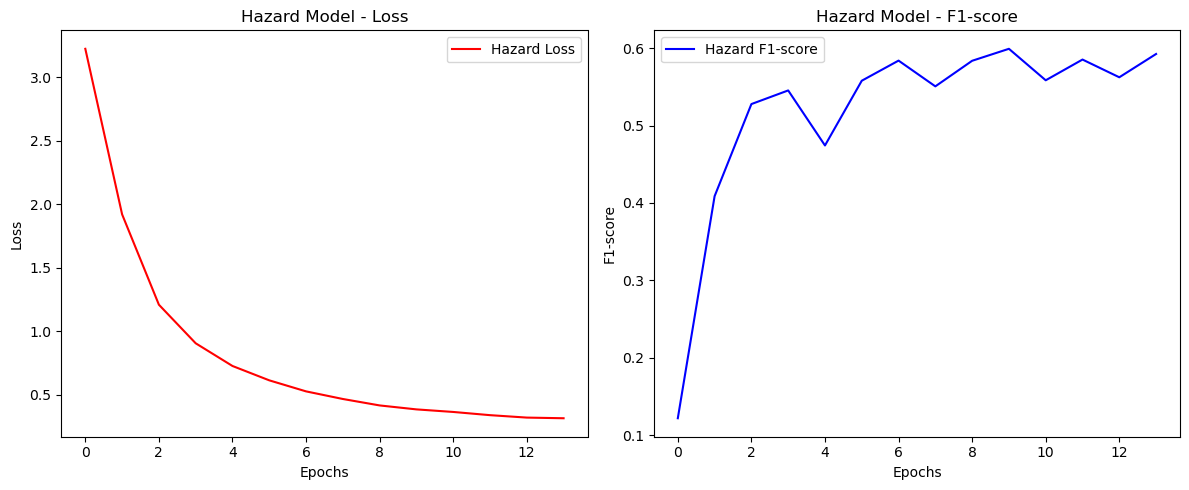

In [87]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

# Hazard Model - Loss
axes[0].plot(history["hazard_loss"], label="Hazard Loss", color="red")
axes[0].set_title("Hazard Model - Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Hazard Model - F1-score
axes[1].plot(history["hazard_f1"], label="Hazard F1-score", color="blue")
axes[1].set_title("Hazard Model - F1-score")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("F1-score")
axes[1].legend()

plt.tight_layout()
plt.show()

* We see this in the plots too that it was correct to stop where we stoped since loss reached a possible platau.

* Also we see the obvious fluctuations of our model when it reaches close to $0.6$ which might mean this is all it could learn.

* Now let's do the same with product predictions

In [37]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs} - Training Product Model (Predicting Product from Clean Text)")

    model_product.train()
    total_loss = 0

    for batch in train_dataloader_pr:
        batch = {k: v.to(device) for k, v in batch.items()}

        if "product_label" not in batch:
            print("Skipping batch - No product labels found!")
            continue

        batch["labels"] = batch.pop("product_label").to(torch.long)
        inputs = {k: batch[k] for k in ["input_ids", "attention_mask", "labels"] if k in batch}
        outputs = model_product(**inputs)

        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        optimizer_product.step()
        lr_scheduler_product.step()
        optimizer_product.zero_grad()

    avg_loss = total_loss / len(train_dataloader_pr)
    print(f"Product Loss: {avg_loss:.4f}")
    history_product["product_loss"].append(avg_loss)

    # Validation Step
    model_product.eval()
    val_preds, true_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader_pr:
            batch = {k: v.to(device) for k, v in batch.items()}
            if "product_label" not in batch:
                continue
            true_labels.extend(batch["product_label"].cpu().numpy())

            inputs = {k: batch[k] for k in ["input_ids", "attention_mask"]}
            outputs = model_product(**inputs)

            predictions = torch.argmax(outputs.logits, dim=-1)
            val_preds.extend(predictions.cpu().numpy())

    if len(true_labels) > 0:
        f1 = f1_score(true_labels, val_preds, average="macro", zero_division=1)
        history_product["product_f1"].append(f1)
        print(f"Validation Product F1-score: {f1:.4f}")

        # Early Stopping Check
        if f1 > best_f1_product["product"]:
            best_f1_product["product"] = f1
            no_improve_epochs_product["product"] = 0
            best_model_product["product"] = copy.deepcopy(model_product.state_dict())
        else:
            no_improve_epochs_product["product"] += 1
            if no_improve_epochs_product["product"] >= patience:
                print(f"Product model stopped early at epoch {epoch+1}. Best F1-score: {best_f1_product['product']:.4f}")
                break



Epoch 1/20 - Training Product Model (Predicting Product from Clean Text)
Product Loss: 6.8492
Validation Product F1-score: 0.0003

Epoch 2/20 - Training Product Model (Predicting Product from Clean Text)
Product Loss: 6.7917
Validation Product F1-score: 0.0003

Epoch 3/20 - Training Product Model (Predicting Product from Clean Text)
Product Loss: 6.7800
Validation Product F1-score: 0.0002

Epoch 4/20 - Training Product Model (Predicting Product from Clean Text)
Product Loss: 6.7739
Validation Product F1-score: 0.0003

Epoch 5/20 - Training Product Model (Predicting Product from Clean Text)
Product Loss: 6.7687
Validation Product F1-score: 0.0002
Product model stopped early at epoch 5. Best F1-score: 0.0003


* Things here are disappointing (and were same when we used title instead of clean text).

* No learning is made.

* Loss is huge $6.8$ and does not go lower in a productive way (in epoch $5$ we are at $6.76$).

* And Validation F1 Macro is far lower than even $0.1$.

* So: **from RoBERTa we keep our model only of hazard.**

* But we must search for other architectures for product.

* Let's go lighter: try **TFIDF**

* The model will incorporate both unigrams and bigrams to capture word relationships, as previous tests with trigrams did not improve results and only using unigrams had lower score.

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2))

# Fit on training & testing data 
X_train_product = vectorizer.fit_transform(train_data['title'])
X_test_product = vectorizer.transform(test_data['title'])

* While Logistic Regression is often used with TF-IDF, it may not provide sufficient predictive power.

* Instead, we will experiment with Random Forests, which can capture complex patterns through ensemble learning.

* A delicate matter in Random Forests is their many hyperparameters.

* We will conduct a broad search by testing $10$ randomly chosen parameter sets.

* Each configuration will be evaluated using 3-fold cross-validation, ensuring better generalization across different training splits.

* This best performing model will then be used to predict test set values.

* (Grid search (with result of braod test) for finer tuning was also tested, but results indicated overfitting and lower scores on test data, so this approach is not presented).

In [95]:
# Labels
y_train_product = train_data['product']
y_test_product = test_data['product']

param_grid = {
    'n_estimators': [100, 200],  # number of trees
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2],  
}

# Product Model
random_search_product = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=4),
    param_distributions=param_grid,
    n_iter=10,  # Try 10 random combinations
    cv=3, scoring="f1_macro", verbose=1, n_jobs=-1
)
random_search_product.fit(X_train_product, y_train_product)

# Retrieve the best model
best_product_model = random_search_product.best_estimator_

# Predict on Test Data using best model
y_test_pred_product_rf = best_product_model.predict(X_test_product)

#F1-score
f1_macro = f1_score(y_test_product, y_test_pred_product_rf, average='macro')
print("F1 Macro Score:", f1_macro)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
F1 Macro Score: 0.27086684994727883


* Much better than RoBERTa.

* We got a $0.27$ F1 Macro scrore for product. 

In [9]:
best_random_params = random_search_product.best_params_
best_random_params

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': None}

* Above are the parameters that led us to this result.

* Since we got such a score there, the question arises: Why not use this Random Forest TFIDF technique to benefit from a good performance new architecture to make RoBERTa predictions better by making the $2$ architectures vote?

* So let's do exactly that.

* Use the same technique to "hazard" label as well.

In [64]:
vectorizer_2 = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2))

# Fit on training and testing data
X_train_hazard_2 = vectorizer_2.fit_transform(train_data['clean-text'])
X_test_hazard_2 = vectorizer_2.transform(test_data['clean_text'])

# Labels
y_train_hazard_2 = train_data['hazard']
y_test_hazard_2 = test_data['hazard']

param_grid = {
    'n_estimators': [100, 200],  # Reduced number of trees
    'max_depth': [None, 10],  # Fewer depth choices
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2],  
}

# Hazard Model
random_search_hazard_2 = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42),
    param_distributions=param_grid,
    n_iter=10,  # Try 10 random combinations
    cv=3, scoring="f1_macro", verbose=1, n_jobs=-1
)
random_search_hazard_2.fit(X_train_hazard_2, y_train_hazard_2)

# Retrieve the best model
best_hazard_model_2 = random_search_hazard_2.best_estimator_

# Predict on Test Data using best model
y_test_pred_hazard_rf_2 = best_hazard_model_2.predict(X_test_hazard_2)

#F1-score
f1_macro_2 = f1_score(y_test_hazard_2, y_test_pred_hazard_rf_2, average='macro')
print("F1 Macro Score:", f1_macro_2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
F1 Macro Score: 0.46924457897325844


* Alright this is a decent score but let's see what we can get with the combination of the $2$ models for hazard : RoBERTa and Random Forest.

* So we start by getting our best RoBERTa Model.

In [34]:
if best_model["hazard"] is not None:
    model_hazard.load_state_dict(best_model["hazard"])
    print("Best hazard model loaded.")

Best hazard model loaded.


* And predicting the test hazards with it.

In [54]:
model_hazard.eval()

test_hazard_logits = []
true_hazards = []

with torch.no_grad():
    for batch in test_dataloader_text:
        batch = {k: v.to(device) for k, v in batch.items()}
        true_hazards.extend(batch["hazard_label"].cpu().numpy())

        # prepare input for RoBERTa
        inputs = {k: batch[k] for k in ["input_ids", "attention_mask"]}
        outputs = model_hazard(**inputs)

        # getting hazard logits
        test_hazard_logits.extend(outputs.logits.cpu().numpy())

# back to String labels
true_hazards = label_enc_hazard.inverse_transform(true_hazards)
test_hazard_preds = label_enc_hazard.inverse_transform(np.argmax(test_hazard_logits, axis=1))

* Now we will follow the following methodology to get the best prediction for hazard:

    * Convert RoBERTa logits to probabilities using the softmax function.
      
    * Get probability estimates from the trained Random Forest model for hazard classification.
    
    * Apply **Soft Voting Ensemble**: combining predictions from RoBERTa (30% weight) and Random Forest (60% weight) to get final probabilities (percentages are result of trial and error).
    
    * Make final predictions by selecting the class with the highest combined probability.
    
    * Convert predictions back to original labels.
    
    * Evaluate performance using the F1 Macro score.

In [78]:
#  RoBERTa logits to probabilities
test_hazard_probs = np.exp(test_hazard_logits) / np.exp(test_hazard_logits).sum(axis=1, keepdims=True)

# Random Forest predictions to probabilities
y_test_pred_hazard_rf_probs_2 = best_hazard_model_2.predict_proba(X_test_hazard_2)

num_classes = test_hazard_probs.shape[1] # Ensure probability arrays are same shape
if y_test_pred_hazard_rf_probs_2.shape[1] < num_classes:
    missing_cols = num_classes - y_test_pred_hazard_rf_probs_2.shape[1]
    y_test_pred_hazard_rf_probs_2 = np.hstack([y_test_pred_hazard_rf_probs_2, np.zeros((y_test_pred_hazard_rf_probs_2.shape[0], missing_cols))])

# Soft Voting: Combine probabilities and Choose the most confident class
final_probs = test_hazard_probs * 0.3 + y_test_pred_hazard_rf_probs_2 * 0.6

# Back to original labels
final_hazard_labels = label_enc_hazard.inverse_transform(final_hazard_preds)

# F1-score for the final ensemble model
f1_ensemble = f1_score(y_test_hazard_2, final_hazard_labels, average='macro')
print("F1 Macro Score (Soft Voting Ensemble):", f1_ensemble)

F1 Macro Score (Soft Voting Ensemble): 0.5590843136593915


* Very good.

* Now let's compute the F1 Macro Score for both hazard and product.

In [97]:
print("\nTask 1 F1-Score:", round(compute_final_score(true_hazards, y_test_product, final_hazard_labels, y_test_pred_product_rf), 4))

F1 Hazard Category:  0.5590843136593915
F1 Product Category:  0.2887640005445524

Task 1 F1-Score: 0.4239


* Our final score for SubTask 2 is $0.4239$.

* But lets's also see the full reports of performance.

In [91]:
print("\nFinal Test Performance - Hazard Classification:")
print(classification_report(true_hazards, final_hazard_labels, zero_division=1))


Final Test Performance - Hazard Classification:
                                                 precision    recall  f1-score   support

                                      Aflatoxin       1.00      1.00      1.00         2
                                 abnormal smell       1.00      0.00      0.00         1
                                alcohol content       1.00      0.00      0.00         1
                                      alkaloids       1.00      1.00      1.00         1
                                      allergens       0.00      0.00      0.00         3
                                         almond       0.83      0.77      0.80        13
           altered organoleptic characteristics       0.00      1.00      0.00         0
                                      amygdalin       1.00      1.00      1.00         1
                         antibiotics, vet drugs       0.01      1.00      0.03         1
                                  bacillus spp.       1.00  

* Some categories achieved perfect precision, recall, and F1-score ($1.00$), such as Aflatoxin, Alkaloids, Amygdalin and Norovirus.

* Several classes have $0.00$ recall and F1-score, meaning the model never predicted them correctly (abnormal smell, alcohol content, allergens, chemical, insufficient labeling).

* This is because even tho augmentation helps significantly, training data must be less rare to get a good model.

* Now let's see product.

In [96]:
report = classification_report(y_test_product, y_test_pred_product_rf)
formatted_report = "\n".join(report.split("\n")) # Format the report to display one line at a time (only needed in Random Forest reports)
print("Final Test Performance - Product Classification")
print(formatted_report)

Final Test Performance - Product Classification
                                                               precision    recall  f1-score   support

                                       Catfishes (freshwater)       0.40      0.67      0.50         3
                                              Dried pork meat       0.00      0.00      0.00         1
                                        Fishes not identified       0.46      0.75      0.57         8
                                           Groupers (generic)       0.00      0.00      0.00         0
                                     Not classified pork meat       0.00      0.00      0.00         3
                          Precooked cooked pork meat products       0.00      0.00      0.00         1
                                            Saurida (generic)       0.00      0.00      0.00         1
                           Torpedo-shaped catfishes (generic)       0.00      0.00      0.00         0
                        

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{

* Many products in the test set were completely absent during training, making it impossible for the model to learn them.
This explains why several categories have zero recall,accuracy and f1 , meaning they were never predicted.

* However, this is a deeper problem of the data used since our model, when compared to the relative leaderboard of competitors' best performances, ranks pretty well (at a bit less than $0.1$ rank difference from the best performance).

* Finally let's save our results.

In [ ]:
subtask2_df = pd.DataFrame({
    "ID": test_data.index,  # row-based ID
    "hazard-pred": test_hazard_preds,
    "product-pred": final_product_preds
})

subtask2_df = pd.DataFrame({
    "ID": test_data.index,  
    "hazard-category-pred": final_hazard_labels,
    "product-category-pred": y_test_pred_product_rf
})

subtask1_df.to_csv("submission_subtask_1.csv", index=False)
subtask2_df.to_csv("submission_subtask_2.csv", index=False)